# Classificação de incêndios florestais utilizando redes neurais convolucionais profundas e Transfer Learning 

<center><img src='https://media4.giphy.com/media/QKUx6kHItu3ilaVMdn/200.webp?cid=ecf05e47gics2m4k7lfvntuuwai9q63i175fusn61o163gvy&rid=200.webp&ct=s' height=300px width=300px></center>

O problema abordado é o de classificação de incêndios florestais, no qual nossa base de dados apresenta imagens de florestas com e sem fogo nelas de resolução 250x250.
A tarefa é relativamente simples, o modelo deve retornar se em uma dada imagem aparece um incêndio, ou não.

O modelo utilizado foi retirado de uma submissão do Kaggle para um problema idêntico ao nosso, mas com outra base de dados. O link para tal submissão é: 
https://www.kaggle.com/code/vencerlanz09/98-fire-classification-cnn-mobilenetv2/notebook



# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from helper_functions import *

import pickle

from tqdm.notebook import tqdm

2022-11-22 04:44:36.747920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 04:44:36.849850: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 04:44:36.849875: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 04:44:37.348413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

# 📥Load and Transform Data

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (250, 250)

# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [3]:
dataset_path = Path("../dataset/training-and-validation")

def data(dir):
    # Get filepaths and labels
    filepaths = list(dir.glob(r'**/*.JPG')) + list(dir.glob(r'**/*.jpg')) + list(dir.glob(r'**/*.jpg'))
    
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    return pd.concat([filepaths, labels], axis=1)

image_df = data(dataset_path)

In [4]:
image_df.head()

,Filepath,Label
0,../dataset/training-and-validation/fire/fire_0...,fire
1,../dataset/training-and-validation/fire/fire_0...,fire
2,../dataset/training-and-validation/fire/fire_0...,fire
3,../dataset/training-and-validation/fire/fire_0...,fire
4,../dataset/training-and-validation/fire/fire_0...,fire


# 🔭Visualizing images from the dataset

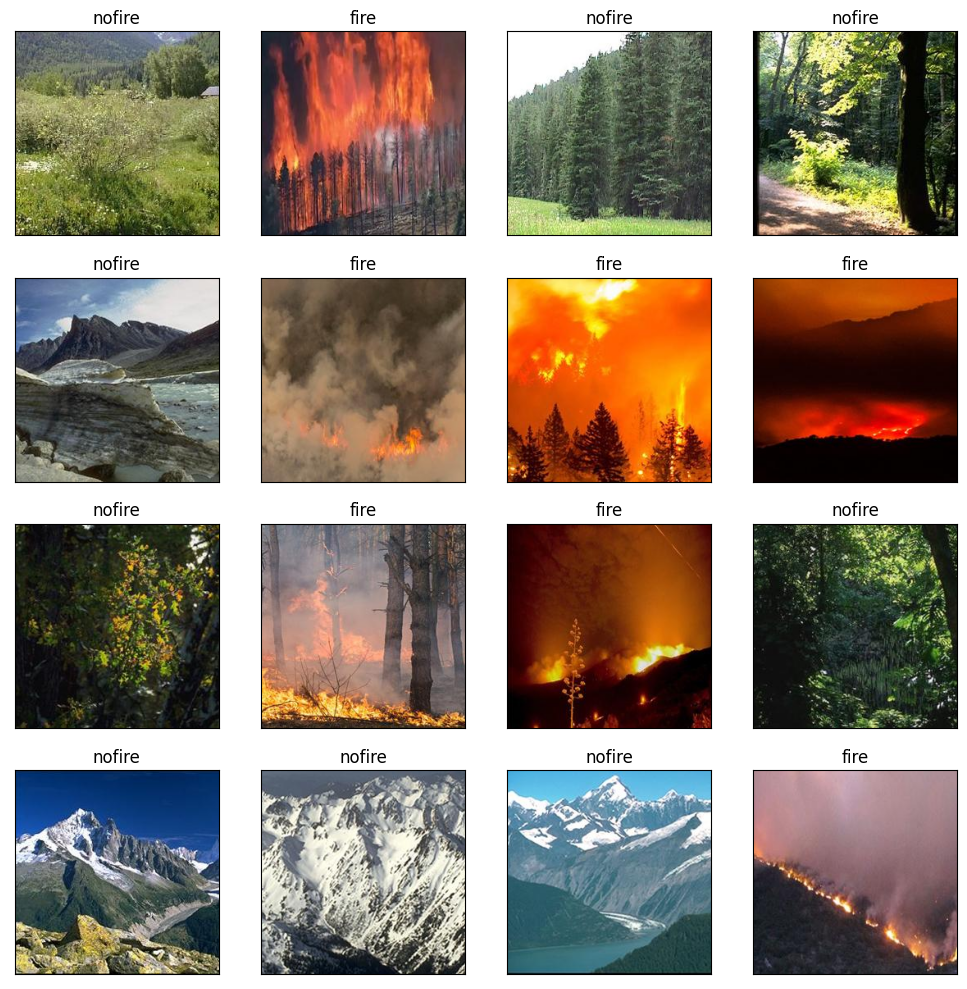

In [5]:
import matplotlib.image as mpimg

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
    
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into two different categories: Training and Validation. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data.

In [21]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.3
)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    rescale=1./255,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 2128 validated image filenames belonging to 2 classes.
Found 912 validated image filenames belonging to 2 classes.


# 🤹🚄 Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

- **Batch size** : 32

- **Epochs** : 100

- **Input Shape** : (250, 250, 3)

- **Output layer** : 2 neurons

In [22]:
# load the pre-trained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_18 (Dense)            (None, 256)               327936    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 2)                 514       
                                                      

In [24]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=1,
    callbacks=[early_stopping]
)

67/67 [==============================] - 32s 459ms/step - loss: 0.2225 - accuracy: 0.9196 - val_loss: 0.0543 - val_accuracy: 0.9857


# 💾 Save & Load Trained Model

Aqui nós treinamos o modelo treinado, após 25 épocas, utilizando Pickle.

In [ ]:
# saves/dumps trained model
with open('trained_model.pkl', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('training_history.pkl', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ✔️Model Evaluation
The validation set will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [25]:
results = model.evaluate(val_images, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.05427
Validation Accuracy: 98.57%


# 📉Visualizing loss curves

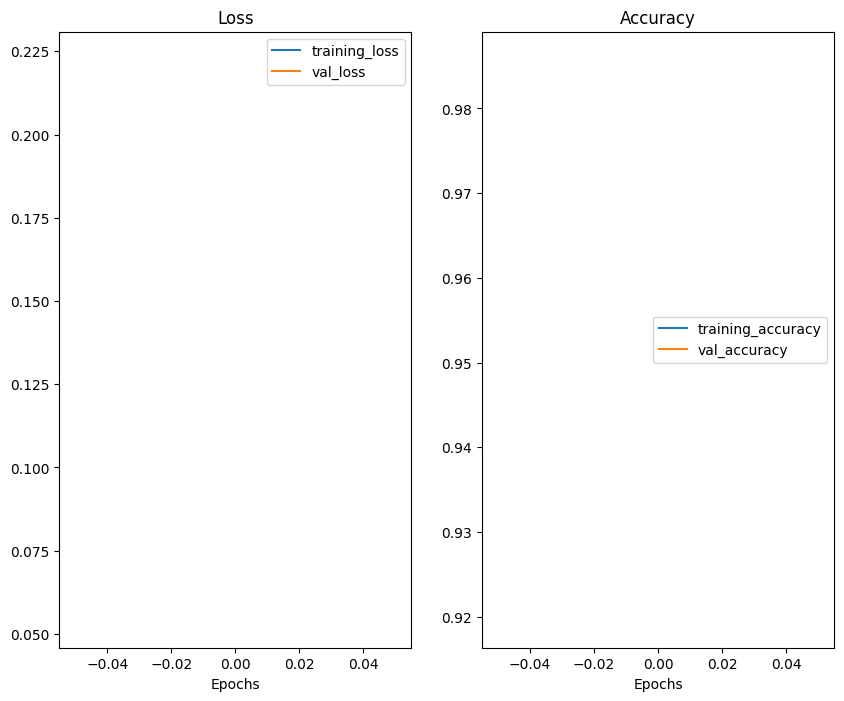

In [26]:
plot_loss_curves(history)

# 🔮Making predictions on the Validation Data

In [ ]:
# Create lists for storing the predictions and labels
to_predict = []
y_true = []

# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
n = len(val_images.labels)

# Loop over the generator
for data, label in val_images:
    # Make predictions on data using the model. Store the results.
    to_predict.extend(data)

    # Store corresponding labels
    y_true.extend(label)

    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
    if (len(to_predict) >= n):
        break

In [ ]:
# Predict the label of the val_images
pred = np.argmax(model.predict(np.array(to_predict)), axis=1)

In [ ]:
# Map the label
labels = dict((v,k) for k,v in train_images.class_indices.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

# 📊Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_true = np.argmax(y_true, axis=1)

In [ ]:
y_true = [labels[k] for k in y_true]

In [ ]:
len(y_true)

In [ ]:
len(pred)

In [ ]:
print(classification_report(y_true, pred))

In [ ]:
report = classification_report(y_true, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
make_confusion_matrix(y_true, pred, list(labels.values()))

Como se pode observar, nossa acurácia nos dados de validação foi de 100%, o que é espantoso, tendo em vista que utilizamos o modelo sem realizar nenhuma alteração significativa nele. Tendo isso em vista, podemos observar o poder adaptativo do transfer learning, que com poucas iterações já obteve uma enorme acurácia no treino e validação. Além disso, o número de imagens utilizado parece ser o suficiente para treinar nossa rede, pelo sucesso obtido no teste.

Entretanto, pelo enorme sucesso do modelo em sua tarefa, levantou-se o questionamento se nosso problema não é simples demais, se por termos utilizado uma base de dados "limpa" (sem pessoas, máquinas e outras coisas que não fazem parte do problema) não facilitamos em excesso o estudo. Sendo assim, é possível que nossa base de dados não seja representativa da realidade, e nosso modelo, apesar de estar funcionando muito bem no teste, ser insuficiente na 'vida real'.

Assim, nosso próximo passo é pensar em como aumentar a complexidade de nossa base de dados para obtermos um modelo mais representativo da realidade. Uma forma de se obter isso seria aumentar nossa base de dados com outros dados não tão "limpos".